# Manipulating kernels


GPflow comes with a range of kernels that can be combined to make new kernels. In this notebook, we examine some of the kernels, show how kernels can be combined, discuss the active_dims feature

In [1]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import tensorflow as tf
%matplotlib inline

## First example

Here is how to create a Matern 3/2 covariance kernel. The only required argument is the dimension of the input space over which the kernel is defined but we will also give provide values for the lengthscale and the variance (if we don't they both have `1.0` as default value).

In [2]:
k = gpflow.kernels.Matern32(input_dim=1, variance=10., lengthscales=2.)

Note that the values we specified for the `variance` and `lengthscales` are **float**. We can get information about the kernel using `print(k)` (plain text) or, in a notebook, simply by entering the kernel name `k`.

In [3]:
k

,class,prior,transform,trainable,shape,fixed_shape,value
Matern32/lengthscales,Parameter,None,+ve,True,(),True,2.0
Matern32/variance,Parameter,None,+ve,True,(),True,10.0


The parameter values can be accessed and assigned new values with the same syntax as for models:

In [4]:
print(k.lengthscales.value)
k.lengthscales = .5
print(k.lengthscales.value)

2.0
0.5


Finally, we can compute the covavariance matrices using the methods `compute_K` or `compute_K_symm`:

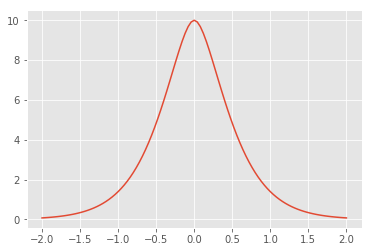

In [5]:
X1 = np.array([[0.]])
X2 = np.linspace(-2, 2, 101).reshape(-1, 1)

K21 = k.compute_K(X2, X1)   # cov(f(X2), f(X1)), matrix with shape [101, 1]
K22 = k.compute_K_symm(X2)  # matrix with shape [101, 101], same output as k.compute_K(X2, X2)

# plotting
plt.figure()
plt.plot(X2, K21)

## Implemented Kernels

GPflow comes with lots of standard kernels. There are a couple of very simple kernels which produce constant functions, linear functions and white noise functions:

 * gpflow.kernels.Constant

 * gpflow.kernels.Linear

 * gpflow.kernels.White

And some stationary functions which produce samples with varying degrees of smoothness:

 * gpflow.kernels.Exponential and gpflow.kernels.Matern12

 * gpflow.kernels.Matern32

 * gpflow.kernels.Matern52

 * gpflow.kernels.SquaredExponential (also known as gpflow.kernels.RBF)

 * gpflow.kernels.RationalQuadratic

And two kernels which produce periodic samples:

 * gpflow.kernels.Cosine

 * gpflow.kernels.Periodic
 
Other kernels that are implemented in core GPflow:
    
 * gpflow.kernels.Polynomial

 * gpflow.kernels.ArcCosine ("neural network kernel")

 * gpflow.kernels.Coregion
 
Let's define some plotting utils functions and have a look at samples from the prior for some of them:

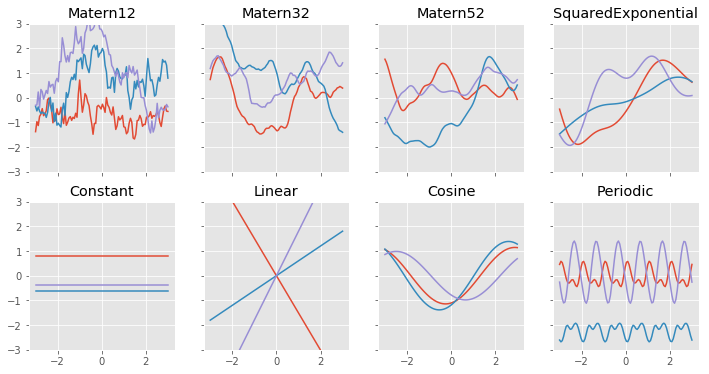

In [6]:
def plotkernelsample(k, ax, xmin=-3, xmax=3):
    xx = np.linspace(xmin, xmax, 100)[:,None]
    K = k.compute_K_symm(xx)
    ax.plot(xx, np.random.multivariate_normal(np.zeros(100), K, 3).T)
    ax.set_title(k.__class__.__name__)
    
np.random.seed(27)
f, axes = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey=True)
plotkernelsample(gpflow.kernels.Matern12(1), axes[0,0])
plotkernelsample(gpflow.kernels.Matern32(1), axes[0,1])
plotkernelsample(gpflow.kernels.Matern52(1), axes[0,2])
plotkernelsample(gpflow.kernels.RBF(1), axes[0,3])
plotkernelsample(gpflow.kernels.Constant(1), axes[1,0])
plotkernelsample(gpflow.kernels.Linear(1), axes[1,1])
plotkernelsample(gpflow.kernels.Cosine(1), axes[1,2])
plotkernelsample(gpflow.kernels.Periodic(1), axes[1,3])
axes[0,0].set_ylim(-3, 3);

## Combining kernels
Valid kernels can be made by adding and multiplying kernels. To do this in GPflow, you can add or multiply intances of kernels, which creates a new kernel with the parameters of the old ones. 

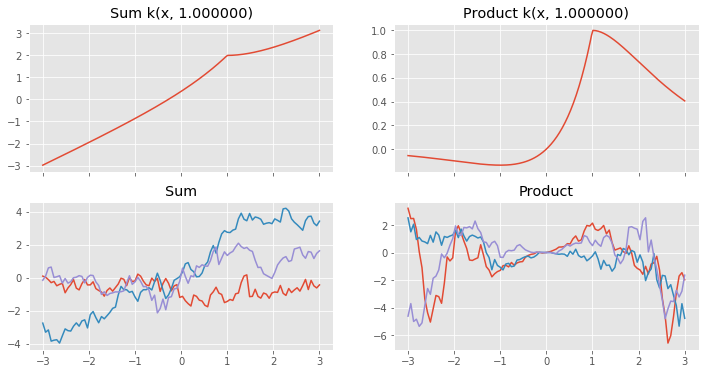

In [7]:
k1 = gpflow.kernels.Matern12(input_dim=1)
k2 = gpflow.kernels.Linear(input_dim=1)

k3 = k1 + k2
k4 = k1 * k2

def plotkernelfunction(k, ax, xmin=-3, xmax=3, other=0):
    xx = np.linspace(xmin, xmax, 200)[:,None]
    ax.plot(xx, k.compute_K(xx, np.zeros((1,1)) + other))
    ax.set_title(k.__class__.__name__ + ' k(x, %f)'%other)

f, axes = plt.subplots(2, 2, figsize=(12, 6), sharex=True)
plotkernelfunction(k3, axes[0, 0], other=1.)
plotkernelfunction(k4, axes[0, 1], other=1.)
plotkernelsample(k3, axes[1, 0])
plotkernelsample(k4, axes[1, 1])

## Kernels on multiple dimensions
The first, obligatory argument to every kernel is *input_dim*, which in the above has been 1. to make a kernel which works on more inputs (columns of X), simply specify a different input_dim. 

Stationary kernels all have ARD options, which allows the user to have one lengthscale parameter per input. 

In [8]:
k = gpflow.kernels.Matern52(input_dim=5)
k

,class,prior,transform,trainable,shape,fixed_shape,value
Matern52/lengthscales,Parameter,None,+ve,True,(),True,1.0
Matern52/variance,Parameter,None,+ve,True,(),True,1.0


In [9]:
k = gpflow.kernels.Matern52(input_dim=5, ARD=True)
k

,class,prior,transform,trainable,shape,fixed_shape,value
Matern52/lengthscales,Parameter,None,+ve,True,"(5,)",True,"[1.0, 1.0, 1.0, 1.0, 1.0]"
Matern52/variance,Parameter,None,+ve,True,(),True,1.0


The lengthscales can also be initialised when the object is created:

In [10]:
k = gpflow.kernels.Matern52(input_dim=5, lengthscales=np.array([.1, .2, 5., 5., 5.]))
k

,class,prior,transform,trainable,shape,fixed_shape,value
Matern52/lengthscales,Parameter,None,+ve,True,"(5,)",True,"[0.1, 0.2, 5.0, 5.0, 5.0]"
Matern52/variance,Parameter,None,+ve,True,(),True,1.0


## Active dimensions

When combining kernels, it's often helpful to have bits of the kernel working on different dimensions. For example, to model a function that is linear in the first dimension and smooth in the second, we could use a combination of Linear and Matern52 kernels, one for each dimension.

To tell GPflow which dimension a kernel applies to, one specifies the active_dims, which is a list of integers. Note that the `input_dim` of the kernel corresponds to the length of the `active_dims` vector.


In [11]:
k1 = gpflow.kernels.Linear(1, active_dims=[0])
k2 = gpflow.kernels.Matern52(1, active_dims=[1])
k = k1 + k2

k

,class,prior,transform,trainable,shape,fixed_shape,value
Sum/kernels/0/variance,Parameter,None,+ve,True,(),True,1.0
Sum/kernels/1/lengthscales,Parameter,None,+ve,True,(),True,1.0
Sum/kernels/1/variance,Parameter,None,+ve,True,(),True,1.0


## See also

GPflow makes it easy to define new covariance functions. This is covered in the notebook [kernel design](../tailor/kernel_design.ipynb).